# Representação Vetorial de Texto

Modelos de aprendizado de máquina, incluindo redes neurais, não operam sobre texto puro. Eles requerem que a entrada de dados seja representada como vetores numéricos. O campo do Processamento de Linguagem Natural (PLN) desenvolveu diversas técnicas para realizar essa conversão, um processo conhecido como *feature extraction* ou vetorização. A qualidade dessa representação vetorial é fundamental para o desempenho do modelo final, pois ela deve capturar as propriedades sintáticas e semânticas da linguagem de forma que o modelo possa generalizar o conhecimento adquirido.

# 1. Tokenização

Antes que qualquer representação vetorial possa ser criada, o texto bruto deve ser segmentado em suas unidades constituintes. Esse processo é chamado de **tokenização**. As unidades resultantes são chamadas de **tokens**. A escolha da estratégia de tokenização é um passo fundamental que impacta todo o pipeline de PLN.

Após a tokenização, o próximo passo é construir um **vocabulário**, que é o conjunto de todos os tokens únicos presentes em um corpus de texto. A finalidade do vocabulário é criar um mapeamento determinístico entre cada token e um índice numérico (um inteiro). Esse mapeamento é a base para todas as formas de representação vetorial.

## Tokenização por Caractere

A forma mais granular de tokenização é tratar cada caractere como um token individual.

* **Vantagens**: O vocabulário é muito pequeno e controlado (letras, números, símbolos). O modelo nunca encontrará um token "fora do vocabulário" (out-of-vocabulary, OOV).
* **Desvantagens**: A noção de palavra é perdida no nível de entrada, e o modelo precisa aprender a compor palavras a partir de caracteres. As sequências de entrada tornam-se muito longas, aumentando o custo computacional.

In [7]:
text_sample = "IA Generativa."

# Tokenização por caractere
char_tokens = list(text_sample)
char_vocab = sorted(list(set(char_tokens)))
char_to_ix = {ch: i for i, ch in enumerate(char_vocab)}

# Mapeando tokens para inteiros
encoded_chars = [char_to_ix[ch] for ch in char_tokens]

print(f"Texto original: '{text_sample}'")
print(f"Tokens de caractere: {char_tokens}")
print(f"Vocabulário de caracteres: {char_vocab}")
print(f"Sequência codificada: {encoded_chars}")

Texto original: 'IA Generativa.'
Tokens de caractere: ['I', 'A', ' ', 'G', 'e', 'n', 'e', 'r', 'a', 't', 'i', 'v', 'a', '.']
Vocabulário de caracteres: [' ', '.', 'A', 'G', 'I', 'a', 'e', 'i', 'n', 'r', 't', 'v']
Sequência codificada: [4, 2, 0, 3, 6, 8, 6, 9, 5, 10, 7, 11, 5, 1]


## Tokenização por Palavra

Esta é a abordagem mais intuitiva, onde o texto é dividido com base em espaços em branco e pontuação.

* **Vantagens**: Preserva a unidade semântica da palavra. É computacionalmente eficiente.
* **Desvantagens**: O tamanho do vocabulário pode se tornar extremamente grande. O modelo é incapaz de lidar com palavras que não viu durante o treinamento (problema OOV). Palavras com flexões morfológicas (e.g., "aprende", "aprendendo", "aprendeu") são tratadas como tokens distintos.

In [8]:
import re

text_sample = "IA Generativa é um campo fascinante, talvez o mais importante da inteligência artificial!"

# Regex para encontrar sequências de caracteres alfanuméricos (incluindo acentos) ou pontuações isoladas.
word_tokens = re.findall(r'[\w]+|[.,!?]', text_sample.lower())
word_vocab = sorted(list(set(word_tokens)))
word_to_ix_map = {word: i for i, word in enumerate(word_vocab)}

print(f"Texto original: '{text_sample}'")
print(f"Tokens de palavra: {word_tokens}")
print(f"Vocabulário de palavras: {word_vocab}")

Texto original: 'IA Generativa é um campo fascinante, talvez o mais importante da inteligência artificial!'
Tokens de palavra: ['ia', 'generativa', 'é', 'um', 'campo', 'fascinante', ',', 'talvez', 'o', 'mais', 'importante', 'da', 'inteligência', 'artificial', '!']
Vocabulário de palavras: ['!', ',', 'artificial', 'campo', 'da', 'fascinante', 'generativa', 'ia', 'importante', 'inteligência', 'mais', 'o', 'talvez', 'um', 'é']


## Tokenização por Subpalavra

A tokenização por subpalavra busca um meio-termo, segmentando palavras raras em unidades menores e mais frequentes, enquanto mantém palavras comuns como tokens únicos.

* **Vantagens**: Controla o tamanho do vocabulário, elimina o problema de OOV e pode capturar relações morfológicas (e.g., "generativa" e "geração" podem compartilhar o subtoken "gera").
* **Desvantagens**: A implementação é mais complexa.

In [9]:
# Vocabulário hipotético de subpalavras
subword_vocab = {"ia", "generativa", "aprend", "##izado", "##endo", "supervision", "##ado"}

# Palavra a ser tokenizada
word = "aprendizado"

# Lógica de tokenização simplificada
tokens = []
# Encontra a maior subpalavra do vocabulário que corresponde ao início da palavra
if word.startswith("aprend"):
    tokens.append("aprend")
    remaining_part = word[len("aprend"):] # "izado"
    # Adiciona o prefixo '##' para buscar a continuação
    if "##" + remaining_part in subword_vocab:
        tokens.append("##" + remaining_part)

print(f"A palavra '{word}' é tokenizada em: {tokens}")

A palavra 'aprendizado' é tokenizada em: ['aprend', '##izado']


In [10]:
# Palavra desconhecida
word = "supervisionado"
tokens = []
if word.startswith("supervision"):
    tokens.append("supervision")
    remaining_part = word[len("supervision"):]
    if "##" + remaining_part in subword_vocab:
        tokens.append("##" + remaining_part)
        
print(f"A palavra '{word}' é tokenizada em: {tokens}")

A palavra 'supervisionado' é tokenizada em: ['supervision', '##ado']


# 2. One-Hot Encoding

Com um vocabulário de tokens definido, a abordagem mais simples de vetorização é o One-Hot Encoding (OHE). Para um vocabulário de tamanho $V$, cada token $w$ com índice $i_w$ é representado por um vetor $v_w$ de dimensão $V$. Formalmente, a j-ésima componente do vetor $v_w$ é dada pela função delta de Kronecker:

$$(v_w)_j = \delta_{i_w, j} = \begin{cases} 1 & \text{se } j = i_w \\ 0 & \text{se } j \neq i_w \end{cases}$$

Por exemplo, considere o vocabulário `{"o": 0, "gato": 1, "bebe": 2}`.

* O token "gato" tem índice 1. Seu vetor OHE é: `[0, 1, 0]`
* O token "o" tem índice 0. Seu vetor OHE é: `[1, 0, 0]`

A sequência "o gato" seria representada por uma lista de vetores: `[[1, 0, 0], [0, 1, 0]]`.

A principal limitação é a **ortogonalidade** ($v_i^T v_j = 0$ para $i \neq j$), que impede o modelo de capturar qualquer noção de similaridade entre os tokens.

In [11]:
import torch

# Vocabulário e mapeamento
vocab = {"o": 0, "gato": 1, "bebe": 2}
vocab_size = len(vocab)
word_to_ix = vocab

def one_hot_encode(word, word_to_ix):
    vec = torch.zeros(len(word_to_ix))
    if word in word_to_ix:
        vec[word_to_ix[word]] = 1
    return vec

# Exemplo
word_ohe = one_hot_encode("gato", word_to_ix)
print(f"Vocabulário: {vocab}")
print(f"Representação One-Hot: {word_ohe}")

Vocabulário: {'o': 0, 'gato': 1, 'bebe': 2}
Representação One-Hot: tensor([0., 1., 0.])


# 3. Representações Densas: Word Embeddings

As representações esparsas como o One-Hot Encoding apresentam duas desvantagens críticas:
1.  **A Maldição da Dimensionalidade**: Para um vocabulário realista (dezenas de milhares de palavras), os vetores se tornam extremamente grandes e esparsos, tornando o processamento computacionalmente caro e exigindo uma quantidade massiva de dados para que um modelo possa aprender padrões significativos.
2.  **Ausência de Relação Semântica**: A ortogonalidade dos vetores implica que não há uma noção de similaridade. O modelo não consegue inferir que "cão" e "gato" são mais parecidos entre si do que com a palavra "algoritmo".

Para superar isso, foram desenvolvidas as **representações densas**, conhecidas como **word embeddings**. A ideia é representar cada palavra por um vetor de baixa dimensão (tipicamente de 50 a 300 dimensões) com valores de ponto flutuante (números reais). Em vez de cada dimensão corresponder a uma palavra específica, as dimensões representam *features latentes* ou atributos do significado da palavra, que são aprendidos automaticamente a partir dos dados.

O princípio fundamental por trás do aprendizado desses embeddings é a **Hipótese Distribucional**: "uma palavra é caracterizada pela companhia que mantém" (Firth, 1957). Isso significa que palavras que aparecem em contextos textuais similares tendem a ter significados similares. O objetivo, portanto, é aprender uma função de mapeamento $E: w \rightarrow \mathbb{R}^d$ (onde $d \ll |V|$) tal que, se duas palavras $w_1$ e $w_2$ são semanticamente similares, seus vetores $E(w_1)$ e $E(w_2)$ estarão próximos no espaço vetorial.

## O Conceito de Espaço Vetorial Semântico

Esse processo de aprendizado cria um **espaço vetorial semântico**, onde a geometria (distância e direção) entre os vetores captura relações de significado. Por exemplo, a relação vetorial entre "rei" e "rainha" pode ser similar à relação entre "homem" e "mulher", permitindo raciocínios por analogia como:

$$ \vec{v}_{\text{rei}} - \vec{v}_{\text{homem}} + \vec{v}_{\text{mulher}} \approx \vec{v}_{\text{rainha}} $$

Modelos como o Word2Vec são projetados para construir esse espaço a partir de grandes volumes de texto.

## Word2Vec e a Arquitetura Skip-gram

Word2Vec é uma família de modelos que aprende esses embeddings de forma eficiente. Vamos focar na sua arquitetura mais popular, o **Skip-gram**.

### Objetivo e Estrutura do Skip-gram

O objetivo do Skip-gram é, dada uma palavra central $w_c$, prever as palavras que aparecem em sua janela de contexto, $w_o$. O modelo é uma rede neural simples com uma única camada oculta.

1.  **Entrada**: A palavra central $w_c$ é representada como um vetor one-hot de tamanho $|V|$.
2.  **Matriz de Embedding ($W$)**: Uma matriz de pesos de dimensão $|V| \times d$. Multiplicar o vetor one-hot da palavra de entrada por esta matriz é equivalente a selecionar a linha correspondente ao índice da palavra, obtendo seu vetor de embedding $v_{w_c}$ (a camada oculta).
3.  **Matriz de Saída ($W'$)**: Uma segunda matriz de pesos, de dimensão $d \times |V|$.
4.  **Cálculo dos Scores**: O embedding da palavra central $v_{w_c}$ é multiplicado pela matriz de saída $W'$ para produzir um vetor de scores $u$ de dimensão $|V|$. Cada elemento $u_j$ deste vetor é o produto escalar $u_j = v'_{w_j} \cdot v_{w_c}$, onde $v'_{w_j}$ é o "embedding de saída" da j-ésima palavra do vocabulário. Este score mede a similaridade entre a palavra central $w_c$ e cada outra palavra $w_j$ como um potencial contexto.
5.  **Probabilidades de Saída**: Os scores são convertidos em probabilidades usando a função softmax. A probabilidade de uma palavra $w_o$ ser uma palavra de contexto de $w_c$ é dada por:

$$P(w_o | w_c) = \frac{\exp(v'_{w_o} \cdot v_{w_c})}{\sum_{j=1}^{|V|} \exp(v'_{w_j} \cdot v_{w_c})}$$

### Função Objetivo (Loss)

O objetivo do treinamento é ajustar os pesos das matrizes $W$ (os embeddings de entrada) e $W'$ (os embeddings de saída) para maximizar a probabilidade de prever corretamente as palavras de contexto reais. Isso é feito minimizando a função de perda (loss), que é o log-likelihood negativo médio sobre todo o corpus. Para uma única palavra central $w_t$, a perda para seu contexto $C_t$ é:

$$L = - \sum_{w_j \in C_t} \log P(w_j | w_t)$$

Ao final do treinamento, a matriz $W$ contém os vetores de embedding densos e semanticamente ricos que procuramos.

In [12]:
import torch.nn as nn
import torch.optim as optim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [13]:
# Corpus temático sobre IA
corpus_text = """
o modelo de aprendizado supervisionado utiliza dados rotulados. 
um algoritmo de aprendizado profundo treina uma rede neural artificial. 
a rede neural aprende com os dados de entrada. 
o modelo de clusterizacao é um algoritmo de aprendizado nao supervisionado. 
o aprendizado por reforco otimiza uma recompensa.
o modelo generativo cria novos dados.
um bom algoritmo precisa de bons dados para o treinamento.
a rede convolucional é um tipo de rede neural para imagens.
o treinamento de um modelo profundo exige muito poder computacional.
"""

# Pré-processamento e criação do vocabulário
corpus_words = re.findall(r'[\w]+', corpus_text.lower())
vocab = sorted(list(set(corpus_words)))
vocab_size = len(vocab)
word_to_ix = {word: i for i, word in enumerate(vocab)}

In [14]:
# Geração de pares de treinamento
window_size = 2
skipgram_data = []
for i in range(window_size, len(corpus_words) - window_size):
    center_word = corpus_words[i]
    context_indices = list(range(i - window_size, i)) + list(range(i + 1, i + window_size + 1))
    for j in context_indices:
        skipgram_data.append((center_word, corpus_words[j]))

In [15]:
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
    def forward(self, center_word_idx):
        embeds = self.embeddings(center_word_idx)
        out = self.linear(embeds)
        return nn.functional.log_softmax(out, dim=-1)

In [16]:
# Treinamento do modelo
embedding_dim = 8
model = SkipGramModel(vocab_size, embedding_dim)
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(250):
    for center_word_str, context_word_str in skipgram_data:
        center_word_idx = torch.tensor([word_to_ix[center_word_str]], dtype=torch.long)
        context_word_idx = torch.tensor([word_to_ix[context_word_str]], dtype=torch.long)
        model.zero_grad()
        log_probs = model(center_word_idx)
        loss = loss_function(log_probs, context_word_idx)
        loss.backward()
        optimizer.step()

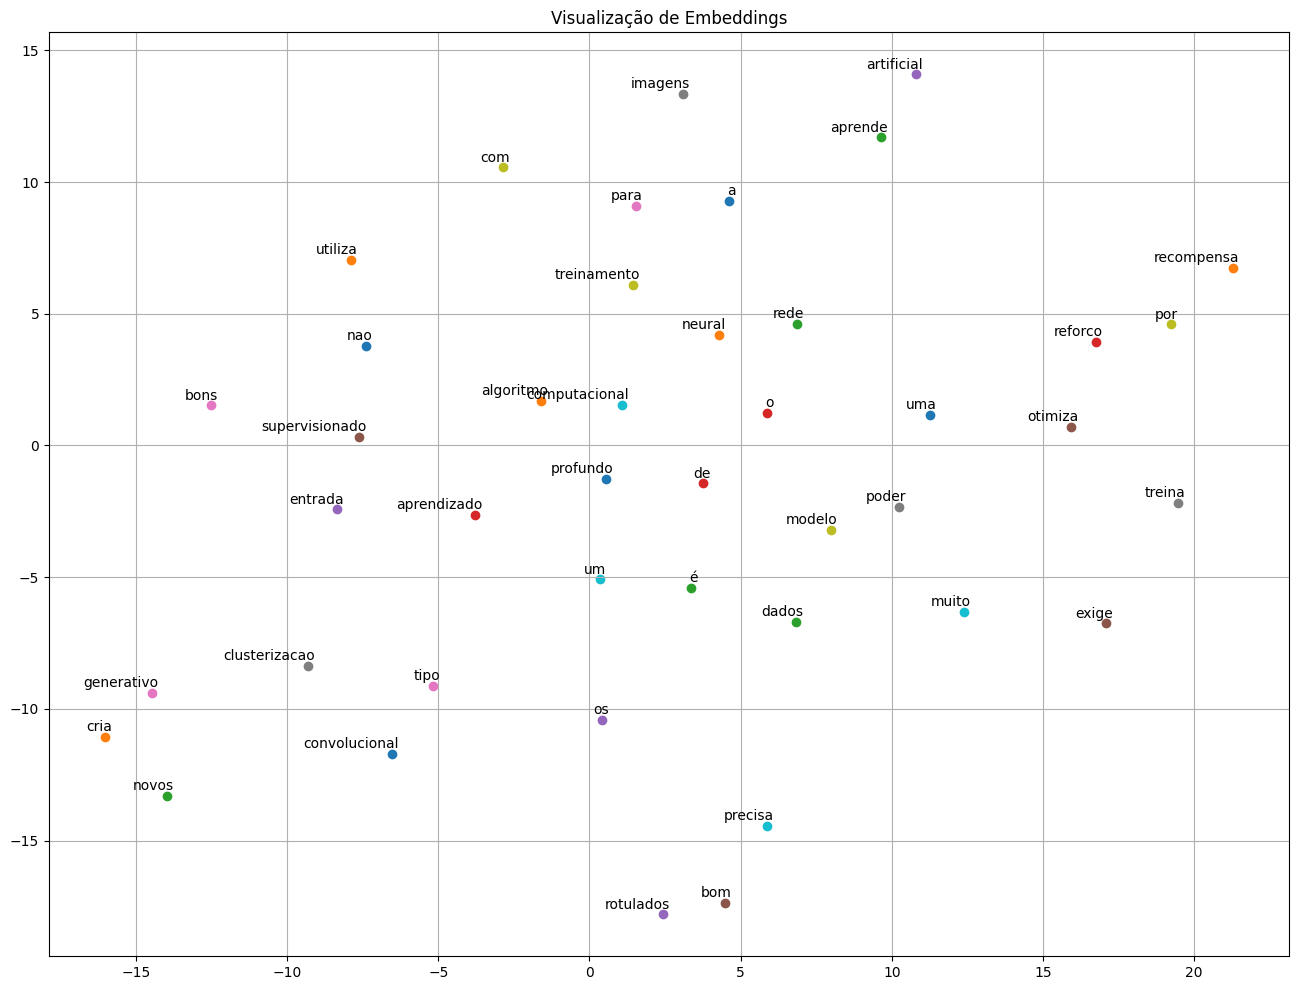

In [17]:
# Visualização
learned_embeddings = model.embeddings.weight.data.numpy()
tsne = TSNE(n_components=2, random_state=42, perplexity=min(10, vocab_size - 1))
embeddings_2d = tsne.fit_transform(learned_embeddings)

plt.figure(figsize=(16, 12))
for i, word in enumerate(vocab):
    x, y = embeddings_2d[i, :]
    plt.scatter(x, y)
    plt.annotate(word, (x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.title("Visualização de Embeddings")
plt.grid(True)
plt.show()

# 4. Utilizando Modelos Word2Vec Pré-treinados

Treinar embeddings do zero é custoso e exige um corpus massivo. Na prática, é comum utilizar modelos pré-treinados em bilhões de palavras (e.g., Wikipedia, Google News). Esses modelos fornecem representações semânticas robustas e de alta qualidade que podem ser usadas diretamente em tarefas de PLN.

A biblioteca `gensim` facilita o download e o uso desses modelos.

In [19]:
import gensim.downloader as api
import numpy as np

# Carregando um modelo pré-treinado (GloVe treinado na Wikipedia, 100 dimensões)
# Modelos disponíveis: print(list(api.info()['models'].keys()))
print("Carregando modelo GloVe")
glove_model = api.load('glove-wiki-gigaword-100')
print("Modelo carregado.")

Carregando modelo GloVe
[==================================================] 100.0% 128.1/128.1MB downloaded
Modelo carregado.


### Explorando o Modelo Pré-treinado

Com o modelo carregado, podemos realizar operações semânticas, como encontrar as palavras mais similares a um dado termo ou resolver analogias.

In [ ]:
print("Palavras mais similares a 'king':")
print(glove_model.most_similar('king'))

In [ ]:
# Resolvendo a analogia: king - man + woman = queen
print("Resolvendo a analogia 'king - man + woman':")
print(glove_model.most_similar(positive=['woman', 'king'], negative=['man']))

### Visualizando Embeddings Pré-treinados

Podemos extrair os vetores de um conjunto de palavras e visualizá-los com t-SNE para confirmar que o espaço semântico é coerente. Note como palavras de categorias similares (países, animais, verbos) se agrupam.

In [ ]:
# Selecionando um conjunto de palavras para visualização
words_to_plot = [
    'king', 'queen', 'prince', 'princess', # Realeza
    'dog', 'cat', 'lion', 'tiger',       # Animais
    'brazil', 'france', 'japan', 'egypt',  # Países
    'run', 'walk', 'swim', 'fly'         # Verbos
]

# Filtrando palavras que existem no vocabulário do modelo
valid_words = [word for word in words_to_plot if word in glove_model]
word_vectors = np.array([glove_model[word] for word in valid_words])

# Redução de dimensionalidade com t-SNE
tsne_plot = TSNE(n_components=2, random_state=42, perplexity=min(10, len(valid_words) - 1))
embeddings_2d_plot = tsne_plot.fit_transform(word_vectors)

# Plotando
plt.figure(figsize=(14, 10))
for i, word in enumerate(valid_words):
    x, y = embeddings_2d_plot[i, :]
    plt.scatter(x, y)
    plt.annotate(word, (x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

plt.title("Visualização de Embeddings Pré-treinados (GloVe)")
plt.grid(True)
plt.show()

# Exercícios

## Exercício 1: Construindo um Tokenizador de Palavras

Crie uma função Python chamada `tokenizador(texto)` que receba uma string como entrada e retorne uma lista de tokens.

Sua função deve atender aos seguintes critérios:
1.  Converter todo o texto para letras minúsculas.
2.  Separar pontuações comuns (como `.`, `,`, `!`, `?`) das palavras. Por exemplo, "Olá!" deve se tornar `['olá', '!']`.
3.  Dividir o texto em tokens com base nos espaços em branco.

In [ ]:
import re
import torch
def tokenizador(texto):
    texto_lower = texto.lower()
    
    tokens = re.findall(r'\w+|[.,!?]', texto_lower)
    
    return tokens

texto_exemplo = "Olá, mundo! Este é um teste de tokenização.8910, 1 2 3, c a b e ç a tinham9esquilos"
tokens_resultado = tokenizador(texto_exemplo)
print(f"Texto original: '{texto_exemplo}'")
print(f"Tokens gerados: {tokens_resultado}")

Texto original: 'Olá, mundo! Este é um teste de tokenização.8910, 1 2 3, c a b e ç a tinham9esquilos'
Tokens gerados: ['olá', ',', 'mundo', '!', 'este', 'é', 'um', 'teste', 'de', 'tokenização', '.', '8910', ',', '1', '2', '3', ',', 'c', 'a', 'b', 'e', 'ç', 'a', 'tinham9esquilos']


## Exercício 2: Criando Representações One-Hot

Utilizando a função `tokenizador` do exercício anterior, crie um pipeline para gerar vetores One-Hot.

Você precisará de duas funções:
1.  `construir_vocabulario(texto, tokenizador)`: Recebe um texto e sua função de tokenização, e retorna um dicionário que mapeia cada token único a um índice (ex: `{'mundo': 0, 'olá': 1, ...}`).
2.  `codificar_one_hot(palavra, vocabulario)`: Recebe uma palavra e o mapa de vocabulário, e retorna seu vetor One-Hot correspondente como um `torch.Tensor`.

In [ ]:
def construir_vocabulario(texto, tokenizador_func):
    tokens = tokenizador_func(texto)
    vocabulario_set = sorted(list(set(tokens)))
    vocab_map = {token: i for i, token in enumerate(vocabulario_set)}
    return vocab_map

def codificar_one_hot(palavra, vocabulario):
    vetor_ohe = torch.zeros(len(vocabulario))
    if palavra in vocabulario:
        indice = vocabulario[palavra]
        vetor_ohe[indice] = 1
    return vetor_ohe

texto_completo = "Olá, mundo! Olá de novo."

vocab = construir_vocabulario(texto_completo, tokenizador)
print(f"Vocabulário construído: {vocab}")

palavra_exemplo = "olá"
vetor_resultado = codificar_one_hot(palavra_exemplo, vocab)
print(f"\nVetor One-Hot para a palavra '{palavra_exemplo}': {vetor_resultado}")

Vocabulário construído: {'!': 0, ',': 1, '.': 2, 'de': 3, 'mundo': 4, 'novo': 5, 'olá': 6}

Vetor One-Hot para a palavra 'olá': tensor([0., 0., 0., 0., 0., 0., 1.])


## Exercício 3: Analogias de Capitais com Embeddings Pré-treinados

Embeddings de palavras capturam relações semânticas. Uma das analogias mais famosas é a de capitais: "Atenas está para a Grécia assim como Oslo está para a Noruega". Matematicamente, isso se traduz em:

$$ \vec{v}_{\text{Atenas}} - \vec{v}_{\text{Grécia}} + \vec{v}_{\text{Noruega}} \approx \vec{v}_{\text{Oslo}} $$

Use o modelo `glove_model` carregado anteriormente para resolver a seguinte analogia: **"Alemanha está para Berlim assim como Brasil está para ?"**.

In [20]:
resultado_analogia = glove_model.most_similar(positive=['berlin', 'brazil'], negative=['germany'])

print("\nResultado para a analogia 'Alemanha está para Berlim assim como Brasil está para ?':")
print(resultado_analogia)


Resultado para a analogia 'Alemanha está para Berlim assim como Brasil está para ?':
[('janeiro', 0.768217921257019), ('paulo', 0.7085851430892944), ('rio', 0.6716135144233704), ('brasilia', 0.6664624810218811), ('aires', 0.6656696796417236), ('buenos', 0.6632315516471863), ('brazilian', 0.6586235761642456), ('mexico', 0.6564258337020874), ('lisbon', 0.6560978889465332), ('sao', 0.6511569023132324)]


## Exercício 4: O Desafio da Polissemia

Um dos problemas de modelos de embedding estáticos como Word2Vec e GloVe é a **polissemia**: uma única palavra pode ter múltiplos significados, mas recebe apenas um único vetor.

O seu desafio é investigar a palavra "bank", que em inglês pode significar uma instituição financeira ou a margem de um rio.

1.  Use o `glove_model` para encontrar os 10 vizinhos mais próximos da palavra "bank".
2.  Analise a lista de vizinhos. Eles se referem ao contexto financeiro, ao geográfico, ou a uma mistura de ambos?

In [21]:
vizinhos_bank = glove_model.most_similar('bank', topn=10)

print("Os 10 vizinhos mais próximos da palavra 'bank' são:")
print(vizinhos_bank)

Os 10 vizinhos mais próximos da palavra 'bank' são:
[('banks', 0.8057132959365845), ('banking', 0.7530707120895386), ('credit', 0.7037603259086609), ('investment', 0.6939943432807922), ('financial', 0.6777413487434387), ('securities', 0.668834388256073), ('lending', 0.664503276348114), ('funds', 0.6484885811805725), ('ubs', 0.6483405232429504), ('finance', 0.6462422609329224)]
